# Convolutional Neural Networks

The fully connected neural network we looked at in the previous lesson takes in a vector as input thus a flattened image could be passed in as input and used for classification problems successfully. But this is not the best way to do it. When trying to interpret an image, the spatial relations between the different pixels is crucial to our understanding. When we flatten the image, we lose this information.

Convolutional neural networks solve this very problem. Rather than performing a matrix multiplication, a convolution operation is performed which can take in a 2d input and give a 2d output hence keep the information about the spatial relations of the pixels. This greatly increases their performance on image and video processing tasks.

In the convolution proccess, you have a filter which you start on the top left side of the image and slide across the whole image, taking a dot product between the values of the filter and pixel values of the image. Bear in mind that colour images have three colour channels so your filter may be 3d so you take the dot product across a 3d volume. Each dot product corresponds to a single activation value in a 2d matrix of neurons which corresponds to a single layer in the output.

![image](images/CNN_RGB.JPG)

The animation below shows how a 1x3x3 filter is applied to a 1x5x5 image. Notice how the output has high  values when the filter is passed over locations where there is an X shape in the input image. This is because the values of the filter are such that it is performing pattern matching for the X shape.

![image](images/convolution_animation.gif)

Convolution operations have 3 parameters, the kernel size, which is the width and height of our filter, the stride, which is the number of pixels we translate our kernel by to compute the next feature, and the padding which is how many layers of 0 padding we add to the input image. We som

![image](images/CNN_diagram.JPG)

Each computed feature is a linear function of the pixels in a local region as opposed to fully connected nets where each computed feature is a linear function of all the pixels in the image.

We have some prior understanding of how image data should be processed. We apply the same set of weights at different locations all over the image because we know that features are repeated at different locations throughout the image. This makes the learned features translation invariant.


![image](images/CNN_FNN_comparison.JPG)


For a long time, operations like this were used in computer vision to find different patterns in images with the engineers having to manually tune the values of the filters to perform the required function. The only difference now is that we apply an activation such as Relu or Sigmoid at each layer and after setting up the structure of the network, we initialize the filter values randomly before using gradient descent to automatically tune the values of the filters. We can also apply max pooling operations to subsample the output at each layer therefore reducing the number of parameters that need to be learned for the succeeding convolution operation.


Just like before, each layer in the whole network learns higher level abstract features from the inputs.

In [1]:
import torch
from torchvision import datasets, transforms

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=transforms.ToTensor(),          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=transforms.ToTensor(),
                           train=False,
                          )

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = train_data[np.random.randint(0, 300)][0]    # get a random example
plt.imshow(x[0].numpy(),cmap='gray')
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [4]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

In [5]:
import torch.nn.functional as F
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
            # conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color channels in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), #28x28
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), #14x14
            torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #14x14
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), #7x7
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(16*7*7, 10) # put your convolutional architecture here using torch.nn.Sequential 
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

In [6]:
use_cuda = torch.cuda.is_available() #checks if gpu is available
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
learning_rate = 0.0005 # set learning rate
epochs = 5# set number of epochs

cnn = ConvNet().to(device)#instantiate model
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [8]:
def train(model, epochs, verbose=True, tag='Loss/Train'):
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            # pass x through your model to get a prediction
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the cost
            if verbose: print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            
            optimiser.zero_grad()                  # reset the gradients attribute of all of the model's params to zero
            loss.backward()                        # backward pass to compute and store all of the model's param's gradients
            optimiser.step()                       # update the model's parameters
            
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
    print('Training Complete. Final loss =',loss.item())

In [9]:
train(cnn, epochs)

Epoch: 0 	Batch: 0 	Loss: 2.302433490753174
Epoch: 0 	Batch: 1 	Loss: 2.302253484725952
Epoch: 0 	Batch: 2 	Loss: 2.3019261360168457
Epoch: 0 	Batch: 3 	Loss: 2.301908016204834
Epoch: 0 	Batch: 4 	Loss: 2.3018157482147217
Epoch: 0 	Batch: 5 	Loss: 2.3011066913604736
Epoch: 0 	Batch: 6 	Loss: 2.3002941608428955
Epoch: 0 	Batch: 7 	Loss: 2.30033278465271
Epoch: 0 	Batch: 8 	Loss: 2.2992284297943115
Epoch: 0 	Batch: 9 	Loss: 2.2994797229766846
Epoch: 0 	Batch: 10 	Loss: 2.2992255687713623
Epoch: 0 	Batch: 11 	Loss: 2.29899263381958
Epoch: 0 	Batch: 12 	Loss: 2.298325777053833
Epoch: 0 	Batch: 13 	Loss: 2.296488046646118
Epoch: 0 	Batch: 14 	Loss: 2.297311305999756
Epoch: 0 	Batch: 15 	Loss: 2.2967824935913086
Epoch: 0 	Batch: 16 	Loss: 2.2950944900512695
Epoch: 0 	Batch: 17 	Loss: 2.2967939376831055
Epoch: 0 	Batch: 18 	Loss: 2.297121524810791
Epoch: 0 	Batch: 19 	Loss: 2.294390916824341
Epoch: 0 	Batch: 20 	Loss: 2.294095039367676
Epoch: 0 	Batch: 21 	Loss: 2.293267011642456
Epoch: 0 	Ba

Epoch: 0 	Batch: 183 	Loss: 1.7071528434753418
Epoch: 0 	Batch: 184 	Loss: 1.7175546884536743
Epoch: 0 	Batch: 185 	Loss: 1.657962679862976
Epoch: 0 	Batch: 186 	Loss: 1.6872034072875977
Epoch: 0 	Batch: 187 	Loss: 1.6772085428237915
Epoch: 0 	Batch: 188 	Loss: 1.7399170398712158
Epoch: 0 	Batch: 189 	Loss: 1.7211289405822754
Epoch: 0 	Batch: 190 	Loss: 1.6784816980361938
Epoch: 0 	Batch: 191 	Loss: 1.7409096956253052
Epoch: 0 	Batch: 192 	Loss: 1.7321337461471558
Epoch: 0 	Batch: 193 	Loss: 1.715440273284912
Epoch: 0 	Batch: 194 	Loss: 1.7139538526535034
Epoch: 0 	Batch: 195 	Loss: 1.7022894620895386
Epoch: 0 	Batch: 196 	Loss: 1.7137175798416138
Epoch: 0 	Batch: 197 	Loss: 1.658056616783142
Epoch: 0 	Batch: 198 	Loss: 1.6949009895324707
Epoch: 0 	Batch: 199 	Loss: 1.6571727991104126
Epoch: 0 	Batch: 200 	Loss: 1.689753532409668
Epoch: 0 	Batch: 201 	Loss: 1.7603977918624878
Epoch: 0 	Batch: 202 	Loss: 1.6393940448760986
Epoch: 0 	Batch: 203 	Loss: 1.6960930824279785
Epoch: 0 	Batch: 

Epoch: 0 	Batch: 359 	Loss: 1.6672279834747314
Epoch: 0 	Batch: 360 	Loss: 1.5890491008758545
Epoch: 0 	Batch: 361 	Loss: 1.6243736743927002
Epoch: 0 	Batch: 362 	Loss: 1.6171622276306152
Epoch: 0 	Batch: 363 	Loss: 1.6831281185150146
Epoch: 0 	Batch: 364 	Loss: 1.6202806234359741
Epoch: 0 	Batch: 365 	Loss: 1.6126012802124023
Epoch: 0 	Batch: 366 	Loss: 1.6289864778518677
Epoch: 0 	Batch: 367 	Loss: 1.664332628250122
Epoch: 0 	Batch: 368 	Loss: 1.590946078300476
Epoch: 0 	Batch: 369 	Loss: 1.6348670721054077
Epoch: 0 	Batch: 370 	Loss: 1.6673099994659424
Epoch: 0 	Batch: 371 	Loss: 1.6608773469924927
Epoch: 0 	Batch: 372 	Loss: 1.6585988998413086
Epoch: 0 	Batch: 373 	Loss: 1.6698089838027954
Epoch: 0 	Batch: 374 	Loss: 1.623528003692627
Epoch: 0 	Batch: 375 	Loss: 1.6986916065216064
Epoch: 0 	Batch: 376 	Loss: 1.619551420211792
Epoch: 0 	Batch: 377 	Loss: 1.6669522523880005
Epoch: 0 	Batch: 378 	Loss: 1.6420472860336304
Epoch: 0 	Batch: 379 	Loss: 1.5997850894927979
Epoch: 0 	Batch: 

Epoch: 1 	Batch: 151 	Loss: 1.6021149158477783
Epoch: 1 	Batch: 152 	Loss: 1.6082199811935425
Epoch: 1 	Batch: 153 	Loss: 1.6380603313446045
Epoch: 1 	Batch: 154 	Loss: 1.6219539642333984
Epoch: 1 	Batch: 155 	Loss: 1.6043143272399902
Epoch: 1 	Batch: 156 	Loss: 1.5868183374404907
Epoch: 1 	Batch: 157 	Loss: 1.623143196105957
Epoch: 1 	Batch: 158 	Loss: 1.6046820878982544
Epoch: 1 	Batch: 159 	Loss: 1.581840991973877
Epoch: 1 	Batch: 160 	Loss: 1.5992563962936401
Epoch: 1 	Batch: 161 	Loss: 1.5863733291625977
Epoch: 1 	Batch: 162 	Loss: 1.589423656463623
Epoch: 1 	Batch: 163 	Loss: 1.6197055578231812
Epoch: 1 	Batch: 164 	Loss: 1.6166867017745972
Epoch: 1 	Batch: 165 	Loss: 1.6426292657852173
Epoch: 1 	Batch: 166 	Loss: 1.6373875141143799
Epoch: 1 	Batch: 167 	Loss: 1.670113205909729
Epoch: 1 	Batch: 168 	Loss: 1.6341859102249146
Epoch: 1 	Batch: 169 	Loss: 1.6062002182006836
Epoch: 1 	Batch: 170 	Loss: 1.6228948831558228
Epoch: 1 	Batch: 171 	Loss: 1.6041315793991089
Epoch: 1 	Batch: 

Epoch: 1 	Batch: 330 	Loss: 1.543813943862915
Epoch: 1 	Batch: 331 	Loss: 1.6405658721923828
Epoch: 1 	Batch: 332 	Loss: 1.6399575471878052
Epoch: 1 	Batch: 333 	Loss: 1.6011998653411865
Epoch: 1 	Batch: 334 	Loss: 1.5908050537109375
Epoch: 1 	Batch: 335 	Loss: 1.6056588888168335
Epoch: 1 	Batch: 336 	Loss: 1.6357053518295288
Epoch: 1 	Batch: 337 	Loss: 1.5789803266525269
Epoch: 1 	Batch: 338 	Loss: 1.6214749813079834
Epoch: 1 	Batch: 339 	Loss: 1.5897530317306519
Epoch: 1 	Batch: 340 	Loss: 1.6091300249099731
Epoch: 1 	Batch: 341 	Loss: 1.6166094541549683
Epoch: 1 	Batch: 342 	Loss: 1.6082428693771362
Epoch: 1 	Batch: 343 	Loss: 1.5929514169692993
Epoch: 1 	Batch: 344 	Loss: 1.5904799699783325
Epoch: 1 	Batch: 345 	Loss: 1.595373272895813
Epoch: 1 	Batch: 346 	Loss: 1.6060175895690918
Epoch: 1 	Batch: 347 	Loss: 1.6378400325775146
Epoch: 1 	Batch: 348 	Loss: 1.7012395858764648
Epoch: 1 	Batch: 349 	Loss: 1.6480275392532349
Epoch: 1 	Batch: 350 	Loss: 1.5907316207885742
Epoch: 1 	Batch

Epoch: 2 	Batch: 120 	Loss: 1.5768306255340576
Epoch: 2 	Batch: 121 	Loss: 1.6425585746765137
Epoch: 2 	Batch: 122 	Loss: 1.5897876024246216
Epoch: 2 	Batch: 123 	Loss: 1.5684094429016113
Epoch: 2 	Batch: 124 	Loss: 1.5870176553726196
Epoch: 2 	Batch: 125 	Loss: 1.6564676761627197
Epoch: 2 	Batch: 126 	Loss: 1.5914055109024048
Epoch: 2 	Batch: 127 	Loss: 1.6107789278030396
Epoch: 2 	Batch: 128 	Loss: 1.5967544317245483
Epoch: 2 	Batch: 129 	Loss: 1.569383978843689
Epoch: 2 	Batch: 130 	Loss: 1.5687514543533325
Epoch: 2 	Batch: 131 	Loss: 1.6253252029418945
Epoch: 2 	Batch: 132 	Loss: 1.6229900121688843
Epoch: 2 	Batch: 133 	Loss: 1.6315985918045044
Epoch: 2 	Batch: 134 	Loss: 1.558089017868042
Epoch: 2 	Batch: 135 	Loss: 1.6002501249313354
Epoch: 2 	Batch: 136 	Loss: 1.608843445777893
Epoch: 2 	Batch: 137 	Loss: 1.5986809730529785
Epoch: 2 	Batch: 138 	Loss: 1.6290433406829834
Epoch: 2 	Batch: 139 	Loss: 1.5859286785125732
Epoch: 2 	Batch: 140 	Loss: 1.6099587678909302
Epoch: 2 	Batch:

Epoch: 2 	Batch: 301 	Loss: 1.613337755203247
Epoch: 2 	Batch: 302 	Loss: 1.570041298866272
Epoch: 2 	Batch: 303 	Loss: 1.646549105644226
Epoch: 2 	Batch: 304 	Loss: 1.5717014074325562
Epoch: 2 	Batch: 305 	Loss: 1.5918515920639038
Epoch: 2 	Batch: 306 	Loss: 1.6255377531051636
Epoch: 2 	Batch: 307 	Loss: 1.5473437309265137
Epoch: 2 	Batch: 308 	Loss: 1.5712393522262573
Epoch: 2 	Batch: 309 	Loss: 1.625139832496643
Epoch: 2 	Batch: 310 	Loss: 1.658483862876892
Epoch: 2 	Batch: 311 	Loss: 1.60835599899292
Epoch: 2 	Batch: 312 	Loss: 1.5747097730636597
Epoch: 2 	Batch: 313 	Loss: 1.5678002834320068
Epoch: 2 	Batch: 314 	Loss: 1.6532320976257324
Epoch: 2 	Batch: 315 	Loss: 1.5668344497680664
Epoch: 2 	Batch: 316 	Loss: 1.5839815139770508
Epoch: 2 	Batch: 317 	Loss: 1.6539593935012817
Epoch: 2 	Batch: 318 	Loss: 1.5716298818588257
Epoch: 2 	Batch: 319 	Loss: 1.5867247581481934
Epoch: 2 	Batch: 320 	Loss: 1.5791144371032715
Epoch: 2 	Batch: 321 	Loss: 1.6237192153930664
Epoch: 2 	Batch: 322

Epoch: 3 	Batch: 91 	Loss: 1.5897908210754395
Epoch: 3 	Batch: 92 	Loss: 1.6078060865402222
Epoch: 3 	Batch: 93 	Loss: 1.5926775932312012
Epoch: 3 	Batch: 94 	Loss: 1.5540786981582642
Epoch: 3 	Batch: 95 	Loss: 1.6472651958465576
Epoch: 3 	Batch: 96 	Loss: 1.5690197944641113
Epoch: 3 	Batch: 97 	Loss: 1.6109521389007568
Epoch: 3 	Batch: 98 	Loss: 1.5950093269348145
Epoch: 3 	Batch: 99 	Loss: 1.5714051723480225
Epoch: 3 	Batch: 100 	Loss: 1.5945528745651245
Epoch: 3 	Batch: 101 	Loss: 1.6089032888412476
Epoch: 3 	Batch: 102 	Loss: 1.6054738759994507
Epoch: 3 	Batch: 103 	Loss: 1.617555022239685
Epoch: 3 	Batch: 104 	Loss: 1.6591253280639648
Epoch: 3 	Batch: 105 	Loss: 1.560549259185791
Epoch: 3 	Batch: 106 	Loss: 1.5972281694412231
Epoch: 3 	Batch: 107 	Loss: 1.6025454998016357
Epoch: 3 	Batch: 108 	Loss: 1.5732767581939697
Epoch: 3 	Batch: 109 	Loss: 1.5680593252182007
Epoch: 3 	Batch: 110 	Loss: 1.58683443069458
Epoch: 3 	Batch: 111 	Loss: 1.5725048780441284
Epoch: 3 	Batch: 112 	Loss

Epoch: 3 	Batch: 267 	Loss: 1.601207971572876
Epoch: 3 	Batch: 268 	Loss: 1.5973230600357056
Epoch: 3 	Batch: 269 	Loss: 1.563311219215393
Epoch: 3 	Batch: 270 	Loss: 1.5829360485076904
Epoch: 3 	Batch: 271 	Loss: 1.5520696640014648
Epoch: 3 	Batch: 272 	Loss: 1.5382683277130127
Epoch: 3 	Batch: 273 	Loss: 1.6331090927124023
Epoch: 3 	Batch: 274 	Loss: 1.6117432117462158
Epoch: 3 	Batch: 275 	Loss: 1.6024216413497925
Epoch: 3 	Batch: 276 	Loss: 1.5636518001556396
Epoch: 3 	Batch: 277 	Loss: 1.5828717947006226
Epoch: 3 	Batch: 278 	Loss: 1.5415936708450317
Epoch: 3 	Batch: 279 	Loss: 1.6126700639724731
Epoch: 3 	Batch: 280 	Loss: 1.6018540859222412
Epoch: 3 	Batch: 281 	Loss: 1.5816998481750488
Epoch: 3 	Batch: 282 	Loss: 1.5785448551177979
Epoch: 3 	Batch: 283 	Loss: 1.6434690952301025
Epoch: 3 	Batch: 284 	Loss: 1.6209001541137695
Epoch: 3 	Batch: 285 	Loss: 1.5866754055023193
Epoch: 3 	Batch: 286 	Loss: 1.593977689743042
Epoch: 3 	Batch: 287 	Loss: 1.6512939929962158
Epoch: 3 	Batch:

Epoch: 4 	Batch: 60 	Loss: 1.6291441917419434
Epoch: 4 	Batch: 61 	Loss: 1.592197060585022
Epoch: 4 	Batch: 62 	Loss: 1.6050281524658203
Epoch: 4 	Batch: 63 	Loss: 1.5695551633834839
Epoch: 4 	Batch: 64 	Loss: 1.5728418827056885
Epoch: 4 	Batch: 65 	Loss: 1.606207251548767
Epoch: 4 	Batch: 66 	Loss: 1.6174769401550293
Epoch: 4 	Batch: 67 	Loss: 1.5716466903686523
Epoch: 4 	Batch: 68 	Loss: 1.5566174983978271
Epoch: 4 	Batch: 69 	Loss: 1.5897644758224487
Epoch: 4 	Batch: 70 	Loss: 1.5553711652755737
Epoch: 4 	Batch: 71 	Loss: 1.5441750288009644
Epoch: 4 	Batch: 72 	Loss: 1.6037622690200806
Epoch: 4 	Batch: 73 	Loss: 1.6248538494110107
Epoch: 4 	Batch: 74 	Loss: 1.5812777280807495
Epoch: 4 	Batch: 75 	Loss: 1.5591871738433838
Epoch: 4 	Batch: 76 	Loss: 1.5366843938827515
Epoch: 4 	Batch: 77 	Loss: 1.5848548412322998
Epoch: 4 	Batch: 78 	Loss: 1.57314133644104
Epoch: 4 	Batch: 79 	Loss: 1.5703563690185547
Epoch: 4 	Batch: 80 	Loss: 1.6313600540161133
Epoch: 4 	Batch: 81 	Loss: 1.590179204

Epoch: 4 	Batch: 238 	Loss: 1.5499002933502197
Epoch: 4 	Batch: 239 	Loss: 1.6248621940612793
Epoch: 4 	Batch: 240 	Loss: 1.5816541910171509
Epoch: 4 	Batch: 241 	Loss: 1.602436900138855
Epoch: 4 	Batch: 242 	Loss: 1.577954649925232
Epoch: 4 	Batch: 243 	Loss: 1.576127290725708
Epoch: 4 	Batch: 244 	Loss: 1.5886421203613281
Epoch: 4 	Batch: 245 	Loss: 1.6021628379821777
Epoch: 4 	Batch: 246 	Loss: 1.6070141792297363
Epoch: 4 	Batch: 247 	Loss: 1.5436336994171143
Epoch: 4 	Batch: 248 	Loss: 1.5969065427780151
Epoch: 4 	Batch: 249 	Loss: 1.5906031131744385
Epoch: 4 	Batch: 250 	Loss: 1.581694483757019
Epoch: 4 	Batch: 251 	Loss: 1.6102293729782104
Epoch: 4 	Batch: 252 	Loss: 1.6316518783569336
Epoch: 4 	Batch: 253 	Loss: 1.5267246961593628
Epoch: 4 	Batch: 254 	Loss: 1.5795459747314453
Epoch: 4 	Batch: 255 	Loss: 1.5855932235717773
Epoch: 4 	Batch: 256 	Loss: 1.600725769996643
Epoch: 4 	Batch: 257 	Loss: 1.5442603826522827
Epoch: 4 	Batch: 258 	Loss: 1.5302079916000366
Epoch: 4 	Batch: 2

In [10]:
import numpy as np
            
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

In [11]:
print('Train Accuracy:', calc_accuracy(cnn, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('Test Accuracy:', calc_accuracy(cnn, test_loader))

Train Accuracy: 88.304
Validation Accuracy: 88.14999999999999
Test Accuracy: 88.41


### Feature Visualisation
Lets visualise the learned features of the network.

Layer Number: 0


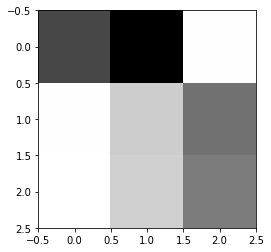

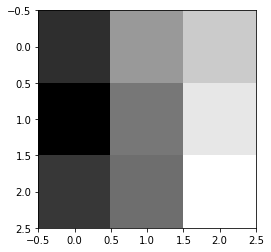

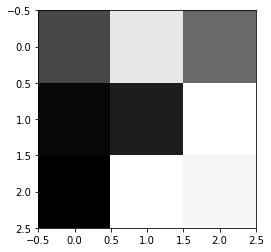

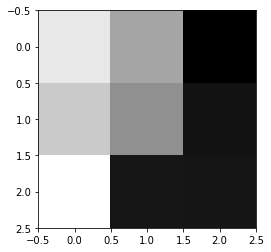

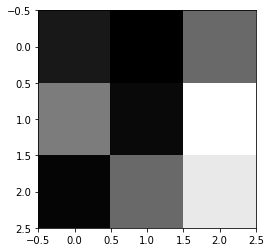

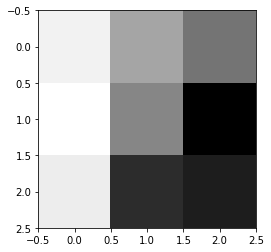

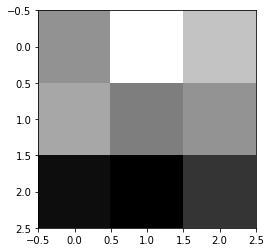

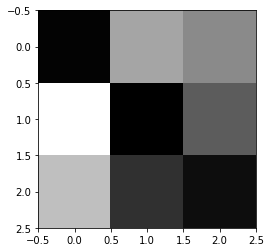

Layer Number: 3


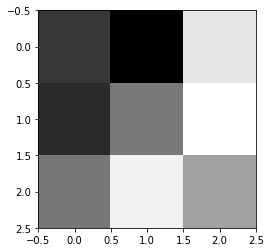

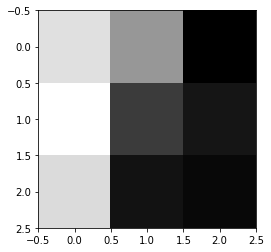

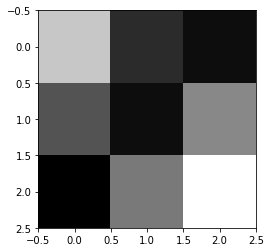

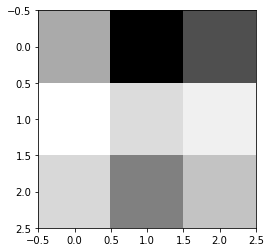

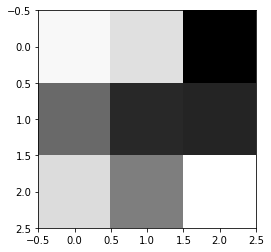

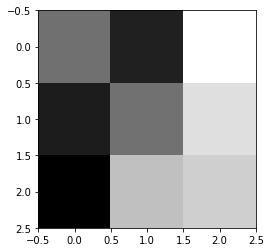

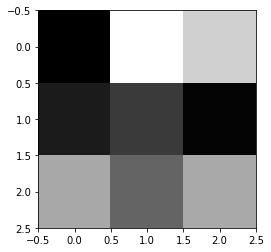

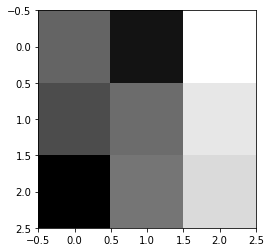

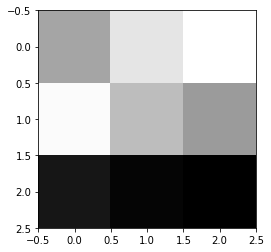

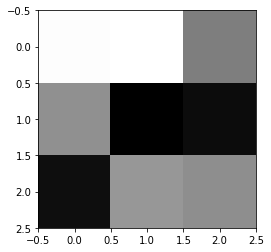

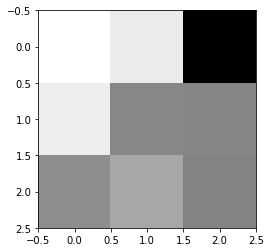

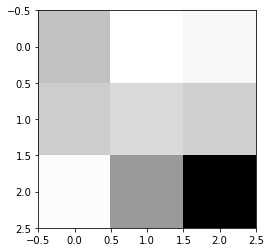

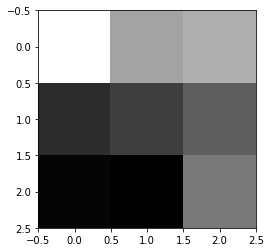

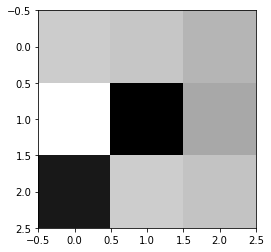

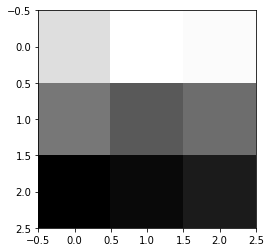

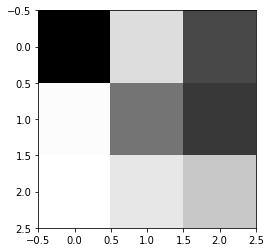

In [12]:
architecture = {0:8, 3:16}
for layer_n in architecture.keys():
    print('Layer Number:', layer_n)
    for i in range(architecture[layer_n]):
        plt.imshow(cnn.conv_layers[layer_n].weight[i].detach().numpy()[0], cmap='gray')
        plt.show()

In [ ]:
Lets find inputs that maximize certain neurons

## Empirical Benchmarking of Fully Connected vs Convolutional Architecture on MNIST

Lets empirically test the translation invariance of the two architectures. 

The training set now has a center crop transformation which crops the central pixels of the image to a given size. However, the test set has a random crop transformation which crops a random region of the image to a given size.

So we are training the neural networks with a centrally cropped image but testing it on cropped images with translations applied.

The network that has more translation invariant features should performs better on this test set.

In [181]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

Train Example


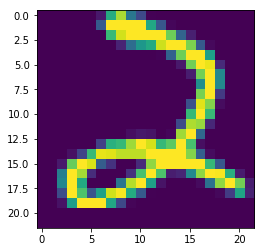

Test Example


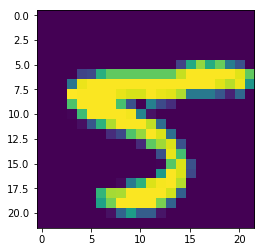

In [93]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, len(train_data))][0]    # get a random training example
print('Train Example')
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, len(test_data))][0]    # get a random test example
print('Test Example')
plt.imshow(x[0].numpy())
plt.show()

In [94]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [95]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

We define the architectures of our fully connected and convolutional networks as well as a function which returns the number of parameters in each model. Since the number of parameters in a model is a rough measure of its capacity, the networks should have an approximately equal number of parameters to make it a fair comparison.

In [102]:
import torch.nn.functional as F 

class FullyConnectedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(crop_size*crop_size, 225),
            torch.nn.ReLU(),
            torch.nn.Linear(225, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10)
        )
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.fc_layers(x)
        x = F.softmax(x, dim=1)
        return x
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64*(crop_size-12)*(crop_size-12), 10) # put your convolutional architecture here using torch.nn.Sequential 
            
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params

In [103]:
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs
# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [104]:
cnn = ConvNet().to(device)#instantiate model
print('Number of parameters in cnn:', get_n_params(cnn))
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(cnn, epochs, verbose=False, tag='CNN Loss/Train')

Number of parameters in cnn: 128522
Training Complete. Final loss = 1.4745460748672485


In [105]:
fnn = FullyConnectedNet().to(device)
print('Number of parameters in fnn:', get_n_params(fnn))
optimiser = torch.optim.Adam(fnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(fnn, epochs, verbose=False, tag='FNN Loss/Train')

Number of parameters in fnn: 137285
Training Complete. Final loss = 1.5748454332351685


In [106]:
print('CNN Train Accuracy:', calc_accuracy(cnn, train_loader))
print('CNN Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('CNN Test Accuracy:', calc_accuracy(cnn, test_loader), '\n')

print('FNN Train Accuracy:', calc_accuracy(fnn, train_loader))
print('FNN Validation Accuracy:', calc_accuracy(fnn, val_loader))
print('FNN Test Accuracy:', calc_accuracy(fnn, test_loader))

CNN Train Accuracy: 97.932
CNN Validation Accuracy: 97.50999999999999
CNN Test Accuracy: 71.98 

FNN Train Accuracy: 87.044
FNN Validation Accuracy: 86.3
FNN Test Accuracy: 46.87


As we can see above, there is a significant disparity between the test accuracy of the two architectures, with the CNN have ~+20% test accuracy

# Scrambling test